In [6]:
import logging
import sys
import datetime
import pickle
from icecream import ic
from tqdm import tqdm
from sklearn.decomposition import PCA
import seaborn as sns

In [79]:
from torch.utils.data import TensorDataset

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt;
np.random.seed(42);
from sklearn.metrics import roc_auc_score;

In [8]:
from sklearn.metrics import roc_auc_score;
from sklearn.metrics import classification_report;

In [9]:
pd.set_option('display.max_columns', None);

In [10]:
df=pd.read_pickle('appmath.pkl')[['graph_id', 'user_id', 
       'goal_id',
        'interaction_end_time',
       'learning_objective_name', 'atom_id', 
       'correct', 'time_spent_answering_s', 'time_spent_on_instruction_s',
       'goal_progress',
       'target_status_and_progress', 'prev_concept_narrative',
       'duration_s', 'is_target']]  

In [11]:
df2=pd.read_csv('prereq_edges.csv')

In [12]:
G=nx.Graph()

for _,i in df2.iterrows():    
       
        G.add_edge(i['source_lo_title'],i['dest_lo_title'])
        
subgraphs=[G.subgraph(i) for i in nx.connected_components(G)]

for num,sub in enumerate(subgraphs):
    
    nx.set_node_attributes(sub,num,'subGraphId')

nodeSubGraphId={}
for g in subgraphs:
    for node in g.nodes(data=True):
         nodeSubGraphId[node[0]]= node[1]['subGraphId']
            
subgraphsNodeCountDict={ num: g.number_of_nodes() for num,g in  enumerate(subgraphs)}

In [13]:
for col in df.columns:
    if df[col].dtype.name=='category':
        df[col]=df[col].astype(str)

In [14]:
df['loGraphID']=df.learning_objective_name.apply(lambda x: nodeSubGraphId.get(x) )

In [15]:
difficulty=df[~df.correct.isna()].groupby('atom_id')['correct'].mean().reset_index().rename(columns={'correct':'difficulty'})
df=df.merge(difficulty,how='left',on='atom_id')

In [16]:
lo_difficulty=df[~df.correct.isna()].groupby('learning_objective_name')['correct'].mean().reset_index().rename(columns={'correct':'lo_difficulty'})
df=df.merge(lo_difficulty,how='left',on='learning_objective_name')


In [17]:
def atomClassifier(x):
    if x==None:
        return 'learningMaterial'
    else:
        return 'question'

In [18]:
df['atom_type']=df.correct.apply(lambda x:atomClassifier(x) )

In [19]:
df['correctBinary']=df.correct*1
df.atom_id=df.atom_id.astype(str)


In [20]:
df=df[~df.correctBinary.isna()]

In [21]:
df2['graph_id']=df2.apply(lambda x: nodeSubGraphId.get(x['source_lo_title']) if nodeSubGraphId.get(x['source_lo_title'])!=None else nodeSubGraphId.get(x['dest_lo_title']),axis=1)

In [22]:
unique_lo_graph_id_dic={}
for i in df2.graph_id.unique():
    unique_lo=np.unique(np.concatenate((df2[df2.graph_id==i]['source_lo_title'].unique(),((df2[df2.graph_id==i]['dest_lo_title'].unique())))))
    unique_lo_graph_id_dic[i]={ item:int(num)  for  num,item in enumerate(unique_lo)}
    df2.loc[df2.graph_id==i,'source_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['source_lo_title']),axis=1)
    df2.loc[df2.graph_id==i,'dest_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['dest_lo_title']),axis=1)

In [23]:
df2.source_index=df2.source_index.astype(int)
df2.dest_index=df2.dest_index.astype(int)

In [24]:
df=df[~df.loGraphID.isna()]

In [25]:
#df['loIndex']=df.apply(lambda x: unique_lo_graph_id_dic[x['loGraphID']].get(x['learning_objective_name'] ),axis=1)

In [26]:
df2[df2.graph_id==3].max()

source_lo_id                    eda7ab6a-8070-4fd8-8387-da17a40fd99e
dest_lo_id                      eda7ab6a-8070-4fd8-8387-da17a40fd99e
source_lo_title    Write biconditional statements in symbolic for...
dest_lo_title      Write biconditional statements in symbolic for...
graph_id                                                           3
source_index                                                      30
dest_index                                                        30
dtype: object

In [27]:
summary=df.pivot_table(index='goal_id',aggfunc={'learning_objective_name':pd.Series.nunique,'atom_id':pd.Series.nunique,'user_id':pd.Series.nunique,'interaction_end_time':np.count_nonzero})

In [28]:
summary['atom_usage']=summary.interaction_end_time/summary.atom_id

In [29]:
summary.sort_values('atom_usage',ascending=False).head(10)

,atom_id,interaction_end_time,learning_objective_name,user_id,atom_usage
goal_id,,,,,
39f38cfd-d153-4fcf-950e-5c1b2bfbeaaa,72,8793,3,289,122.125000
d252b7df-6a57-46ff-b4c3-e21d26d80b6a,82,9887,5,253,120.573171
cd26c1cb-87ad-4b57-bdeb-7e8811827e39,59,5764,3,194,97.694915
86940cba-2a55-43a6-8f51-248afca9952d,26,1974,1,291,75.923077
caacf0e3-8698-4806-8ce8-a45d8f75b587,59,4396,3,240,74.508475
12b7f97f-18be-4a9e-9384-866a036631d4,103,7107,5,260,69.000000
9059c88d-ccdd-42dd-a19f-fe7c9bafd6aa,47,3236,2,255,68.851064
46e93a47-9de8-4982-82ec-6e3acb911c54,116,7116,6,240,61.344828
917d2bb2-451f-4f65-8eec-7a8125c9a596,39,2220,2,140,56.923077


In [31]:
loGraphID=3
user=df[df.loGraphID==loGraphID].user_id.sample(1).values

dfg=df[(df.loGraphID==loGraphID) & (df.user_id.isin(user)) ].reset_index(drop=True)

In [32]:
dfg=dfg.sort_values(['user_id','interaction_end_time'])

In [33]:
atom_index={atom_id:i for i,atom_id  in  enumerate(dfg.atom_id.unique())}

In [34]:
dfg['atomIndex']=dfg.atom_id.map(atom_index)

In [35]:
loEdgeMapping=df2[df2['graph_id']==loGraphID][['source_index','dest_index']]
lo_edges=loEdgeMapping.values.transpose()

In [36]:
lo_map=pd.concat([df2[df2['graph_id']==loGraphID][['source_lo_title','source_index']].rename(columns={'source_lo_title':'learning_objective_name','source_index':'loIndex'}),df2[df2['graph_id']==loGraphID][['dest_lo_title','dest_index']].rename(columns={'dest_lo_title':'learning_objective_name','dest_index':'loIndex'})]).drop_duplicates().reset_index(drop=True)

In [37]:
dfg['atomIndex']=dfg.atom_id.map(atom_index)

In [38]:
#loIndex={lo:i for i,lo in enumerate( dfg.learning_objective_name.unique())}
#dfg['loIndex']=dfg['learning_objective_name'].apply(lambda x: loIndex[x])

In [39]:
dfg=dfg.merge(lo_map,on='learning_objective_name',how='left')

In [40]:
dfg

,graph_id,user_id,goal_id,interaction_end_time,learning_objective_name,atom_id,correct,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,target_status_and_progress,prev_concept_narrative,duration_s,is_target,loGraphID,difficulty,lo_difficulty,atom_type,correctBinary,atomIndex,loIndex
0,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-09-02 00:52:04.940,Solve an application problem by applying Polya...,c2571c28-c337-4831-aecb-3e1d78acaeca,False,707.533020,25.230000,0.007847,{'9e0aedd2-281b-46c5-8024-b8af3fa00cef': {'pro...,NONE,732.763000,True,3.0,0.951754,0.593100,question,0,0,27
1,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-09-02 00:55:03.343,Solve an application problem by applying Polya...,7cae6bd4-3130-4862-af34-60f8dde81549,True,174.817001,3.585000,0.132514,{'9e0aedd2-281b-46c5-8024-b8af3fa00cef': {'pro...,NONE,178.402008,True,3.0,0.801762,0.593100,question,1,1,27
2,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-09-02 01:05:13.907,Solve an application problem by applying Polya...,48ce9017-cd13-48d3-bf31-d48fa5d9a811,True,352.446991,3.236000,0.366208,{'9e0aedd2-281b-46c5-8024-b8af3fa00cef': {'pro...,nan,355.682983,True,3.0,0.763889,0.593100,question,1,2,27
3,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-09-02 01:15:44.174,Solve an application problem by applying Polya...,dbc04c07-a056-4bf5-8ffa-4a15e9dcf382,True,626.796997,3.219000,0.791904,{'9e0aedd2-281b-46c5-8024-b8af3fa00cef': {'pro...,DIRECT_PRE_TEST,630.015991,True,3.0,0.436782,0.593100,question,1,3,27
4,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-09-02 01:21:07.273,Solve an application problem by applying Polya...,8e2f1a4f-3e77-4e91-99df-f27310d357be,False,304.015015,18.889999,0.519215,{'9e0aedd2-281b-46c5-8024-b8af3fa00cef': {'pro...,DIRECT_PRE_TEST,322.905029,True,3.0,0.460526,0.593100,question,0,4,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3d6db559-2455-41e9-aa8a-72e5d498ab20,2022-09-26 03:02:43.213,Determine if a syllogistic argument is valid w...,5de0bb6d-c964-4dea-9836-1429f8716068,True,9.623000,1.645000,0.763311,{'e7ecb73b-8c1a-4ecb-bef2-5a7dd5f6cd16': {'pro...,NONE,11.268000,True,3.0,0.707865,0.612136,question,1,118,8
191,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3d6db559-2455-41e9-aa8a-72e5d498ab20,2022-09-26 03:02:57.369,Determine if a syllogistic argument is valid w...,e962f6ba-8e28-427a-acd5-289bd58972d3,True,11.887000,2.074000,0.849827,{'e7ecb73b-8c1a-4ecb-bef2-5a7dd5f6cd16': {'pro...,NONE,13.961000,True,3.0,0.449438,0.612136,question,1,119,8
192,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3d6db559-2455-41e9-aa8a-72e5d498ab20,2022-09-26 03:03:21.723,Represent a syllogistic argument with a Euler ...,74b2cfcf-81c9-4cd3-9acf-b0f9e9f0560d,True,22.056999,2.107000,0.951019,{'e7ecb73b-8c1a-4ecb-bef2-5a7dd5f6cd16': {'pro...,NONE,24.164000,True,3.0,0.763736,0.675532,question,1,120,23
193,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,730a7838-991b-4fd0-a553-443047a67277,3d6db559-2455-41e9-aa8a-72e5d498ab20,2022-09-26 03:03:30.452,Represent a syllogistic argument with a Euler ...,eac21ab9-4930-4577-ab3f-94a2767dc221,True,6.158000,2.371000,0.997647,{'e7ecb73b-8c1a-4ecb-bef2-5a7dd5f6cd16': {'pro...,NONE,8.529000,True,3.0,0.425000,0.675532,question,1,63,23


In [41]:
question_sequence=dfg[['loIndex','atomIndex','correctBinary']].values.transpose()

In [42]:
lo_atom_edges_list=dfg.groupby(['loIndex','atomIndex'])['graph_id'].nunique().index.to_list()

In [43]:
question_sequence_len=question_sequence.shape[1]



In [44]:
l1,l2=zip(*lo_atom_edges_list)


In [45]:
lo_atom_edges=np.array((list(l1),list(l2)))

In [46]:
#loFeatures=dfg.groupby('loIndex')['lo_difficulty'].mean().values.reshape(-1,1)
atomFeatures=dfg.groupby('atomIndex')['difficulty'].mean().values.reshape(-1,1)
loFeatures=np.zeros(31 ).reshape(-1,1)

In [47]:
from torch_geometric.data import HeteroData
import torch 


In [48]:
data = HeteroData()

In [49]:
data['atom'].x=torch.tensor(atomFeatures.astype(np.float64)).float()
#data['atom'].y=torch.tensor(atomFeatures.astype(np.float64)).float()
data['lo'].x= torch.tensor(loFeatures.astype(np.float64)).float()

In [50]:
data['lo','lo_atom','atom'].edge_index=torch.from_numpy(lo_atom_edges).long()
data['lo','lo_lo','lo'].edge_index=torch.from_numpy(lo_edges).long()

In [51]:
import torch_geometric.transforms as T

In [52]:
normalize=T.NormalizeFeatures()
data=normalize(data)

In [53]:
import torch_geometric as pyg
from torch_geometric.nn import GCNConv 
from torch_geometric.nn import SAGEConv, to_hetero ,LSTMAggregation
import  torch.nn as nn
import torch.nn.functional as F
import torch 
from torch_geometric.loader import DataLoader

In [54]:
data.metadata()

(['atom', 'lo'], [('lo', 'lo_atom', 'atom'), ('lo', 'lo_lo', 'lo')])

In [55]:
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [56]:
hidden_channels=100
final_layer_dim=hidden_channels/4
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=True)
        self.actfn1=nn.ReLU()
        
        self.conv2 = SAGEConv((-1, -1),int( hidden_channels/2),requires_grad=True)
        self.actfn2=nn.ReLU()
        
        self.conv3 = SAGEConv((-1, -1),int( final_layer_dim),requires_grad=True)
        self.actfn3=nn.ReLU()
        
        self.conv4 = SAGEConv((-1, -1),int( hidden_channels/8),requires_grad=True)
        self.actfn4=nn.ReLU()
        
        
        self.sigmoid= nn.Sigmoid()

    def forward(self, x, edge_index):
        
        x = self.actfn1(self.conv1(x, edge_index))
        #x= F.dropout(x,p=.5,training=self.training)
        
        x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.7,training=self.training)
        
        x = self.actfn3(self.conv3(x, edge_index))
        
        #out = self.actfn4(self.conv4(x, edge_index))
        
        #out= F.dropout(x,p=.7,training=self.training)
        #pool={key: gmp(out[key].x, out[key].batch) for key in out.node_types}
        #out=self.sigmoid( self.out(x))
        #ic(pool)
        
        #pool=gmp(out)
        return x

In [57]:
lookback=3
hidden_channels1=int((final_layer_dim)*2*(lookback+1)+(lookback+1))

out_channels=1
class Classifer(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.ins=nn.Linear(hidden_channels1,10)
        self.actfn1=nn.ReLU()
        
        self.ins2=nn.Linear(10,5)
        self.actfn2=nn.ReLU()
        
        self.out=nn.Linear(5,1)
        self.actfn3=nn.Sigmoid()
        
    def forward(self, x):
        
        x= self.actfn1 (self.ins(x))
        
        x= self.actfn2 (self.ins2(x))
        
        out=self.actfn3(self.out(x))
        
        
        return out

In [58]:
class GNN_Classifier(nn.Module):
    def __init__(self):
        super(GNN_Classifier, self).__init__()
        
        self.model_embedding=GNN()
        self.model_embedding = to_hetero(self.model_embedding, data.metadata(),aggr='max')
        self.classifer = Classifer()
        #lo,atom,prev_answer,prev_lo,prev_atom,prev_answer1,prev_lo1,prev_atom1
    def forward(self, x,edges,batch_num,lookback,question_sequence):
        node_embeddings = self.model_embedding(x,edges)
        features_concat_list=[]
        
        for i in range(lookback+1):
            #print([i,batch_num-i])
            lo=question_sequence[0][batch_num-i]
            atom=question_sequence[1][batch_num-i]
            prev_answer=torch.tensor([question_sequence[2][batch_num-1-i]]).float()
            #features_concat_list.extend([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer])
            features_concat_list.extend([node_embeddings['atom'][atom]])
            features_concat_list.extend([node_embeddings['lo'][lo]])
            features_concat_list.extend([prev_answer])
        
                                         
            
        #user_embeddings=torch.cat([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer,node_embeddings['atom'][prev_atom] , node_embeddings['lo'][prev_lo],prev_answer1,node_embeddings['atom'][prev_atom1] , node_embeddings['lo'][prev_lo1]])  
       
        user_embeddings=torch.cat(features_concat_list)
        
        rnn_outputs = self.classifer(user_embeddings)
    
        return rnn_outputs,user_embeddings

In [59]:

model=GNN_Classifier()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=5e-12)
criterion=torch.nn.BCELoss()
#criterion=F.binary_cross_entropy
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
accuracy_list=[]
best_score=0
user_embedings=[]

loss_moving_avg=[]

for epoch_num in range(50):
    epoch_accuracy=[]
    out_list=[]
    total_loss=0
    user_embedings=[]
    prob=[]
    target=[]
    for  batch_num in tqdm(range(lookback,question_sequence_len)):
        
        model.train()
       
        optimizer.zero_grad()   
        #x_dict = {key: gmp(batch[key].x, batch[key].batch) for key in batch.node_types}
        

        answer=torch.tensor([question_sequence[2][batch_num]]).float()
     
        
        out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence) 
        user_embedings.append((node_embeddings,answer))
        loss=F.binary_cross_entropy(out,answer)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        total_loss=total_loss+loss.item()
        train_correct=out.round()==answer
        
        train_acc=train_correct*1
        accuracy=(train_correct*1).item()
        epoch_accuracy.append(accuracy)
        #accuracy_list.append(accuracy)
        prob.append(out.item())
        target.append(answer.item())
    performance='epoch {} | loss {:.5f} | accuracy {:.5f} | auc {:.5f}'.format(epoch_num,total_loss/(batch_num+1),np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print(performance)
    loss_moving_avg.append(total_loss/(batch_num+1))
            
    #ic((epoch_num,np.mean(epoch_accuracy),loss.item()))
    

#out['target']: tensor([[0.2217, 0.0272]], grad_fn=<AddmmBackward0>)

100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.20it/s]


epoch 0 | loss 0.68245 | accuracy 0.52604 | auc 0.45109


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.11it/s]


epoch 1 | loss 0.67727 | accuracy 0.53646 | auc 0.56721


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.80it/s]


epoch 2 | loss 0.64527 | accuracy 0.61458 | auc 0.67647


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.85it/s]


epoch 3 | loss 0.61658 | accuracy 0.64583 | auc 0.70795


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.38it/s]


epoch 4 | loss 0.60641 | accuracy 0.67188 | auc 0.71961


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.72it/s]


epoch 5 | loss 0.60011 | accuracy 0.68229 | auc 0.72985


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.58it/s]


epoch 6 | loss 0.59608 | accuracy 0.69792 | auc 0.73464


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 45.72it/s]


epoch 7 | loss 0.59412 | accuracy 0.69792 | auc 0.73736


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 45.95it/s]


epoch 8 | loss 0.59276 | accuracy 0.69792 | auc 0.74009


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.98it/s]


epoch 9 | loss 0.58955 | accuracy 0.69271 | auc 0.74303


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 51.43it/s]


epoch 10 | loss 0.58627 | accuracy 0.70833 | auc 0.74553


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 51.43it/s]


epoch 11 | loss 0.58312 | accuracy 0.70833 | auc 0.74880


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 50.96it/s]


epoch 12 | loss 0.58099 | accuracy 0.71354 | auc 0.75098


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.89it/s]


epoch 13 | loss 0.57885 | accuracy 0.71354 | auc 0.75479


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 49.07it/s]


epoch 14 | loss 0.57631 | accuracy 0.71354 | auc 0.75479


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.59it/s]


epoch 15 | loss 0.57573 | accuracy 0.70312 | auc 0.75490


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.00it/s]


epoch 16 | loss 0.57399 | accuracy 0.70312 | auc 0.75730


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 45.10it/s]


epoch 17 | loss 0.57330 | accuracy 0.70833 | auc 0.75610


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.07it/s]


epoch 18 | loss 0.57076 | accuracy 0.70312 | auc 0.75763


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.23it/s]


epoch 19 | loss 0.56949 | accuracy 0.70312 | auc 0.75915


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.58it/s]


epoch 20 | loss 0.56891 | accuracy 0.70312 | auc 0.75893


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.89it/s]


epoch 21 | loss 0.57011 | accuracy 0.70312 | auc 0.76002


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.07it/s]


epoch 22 | loss 0.56896 | accuracy 0.70833 | auc 0.76373


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.78it/s]


epoch 23 | loss 0.56654 | accuracy 0.70312 | auc 0.76612


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.79it/s]


epoch 24 | loss 0.56460 | accuracy 0.71354 | auc 0.76928


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 49.75it/s]


epoch 25 | loss 0.56326 | accuracy 0.71354 | auc 0.76895


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 49.86it/s]


epoch 26 | loss 0.56141 | accuracy 0.70833 | auc 0.77288


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.02it/s]


epoch 27 | loss 0.55828 | accuracy 0.71354 | auc 0.77636


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.12it/s]


epoch 28 | loss 0.55513 | accuracy 0.71354 | auc 0.78039


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.99it/s]


epoch 29 | loss 0.55637 | accuracy 0.71875 | auc 0.78050


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.04it/s]


epoch 30 | loss 0.55330 | accuracy 0.70833 | auc 0.78344


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.52it/s]


epoch 31 | loss 0.55126 | accuracy 0.70833 | auc 0.78682


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.35it/s]


epoch 32 | loss 0.54977 | accuracy 0.71875 | auc 0.78889


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.89it/s]


epoch 33 | loss 0.54619 | accuracy 0.71875 | auc 0.79107


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.74it/s]


epoch 34 | loss 0.54663 | accuracy 0.71354 | auc 0.79183


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.94it/s]


epoch 35 | loss 0.54368 | accuracy 0.71875 | auc 0.79259


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.70it/s]


epoch 36 | loss 0.54021 | accuracy 0.72396 | auc 0.79532


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 49.22it/s]


epoch 37 | loss 0.53689 | accuracy 0.72396 | auc 0.80087


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 51.07it/s]


epoch 38 | loss 0.53450 | accuracy 0.72917 | auc 0.80512


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 49.34it/s]


epoch 39 | loss 0.53144 | accuracy 0.72917 | auc 0.80556


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.96it/s]


epoch 40 | loss 0.53364 | accuracy 0.72917 | auc 0.80349


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 47.96it/s]


epoch 41 | loss 0.52845 | accuracy 0.72917 | auc 0.80806


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.15it/s]


epoch 42 | loss 0.52612 | accuracy 0.73438 | auc 0.80850


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.85it/s]


epoch 43 | loss 0.52571 | accuracy 0.72396 | auc 0.80697


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:04<00:00, 46.71it/s]


epoch 44 | loss 0.52461 | accuracy 0.72917 | auc 0.80882


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.30it/s]


epoch 45 | loss 0.52327 | accuracy 0.73438 | auc 0.81187


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 51.22it/s]


epoch 46 | loss 0.51920 | accuracy 0.72396 | auc 0.81547


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 49.40it/s]


epoch 47 | loss 0.51778 | accuracy 0.72917 | auc 0.81590


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 49.72it/s]


epoch 48 | loss 0.51754 | accuracy 0.72917 | auc 0.81808


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:03<00:00, 48.04it/s]

epoch 49 | loss 0.51582 | accuracy 0.72917 | auc 0.81895


In [60]:
performance

'epoch 49 | loss 0.51582 | accuracy 0.72917 | auc 0.81895'

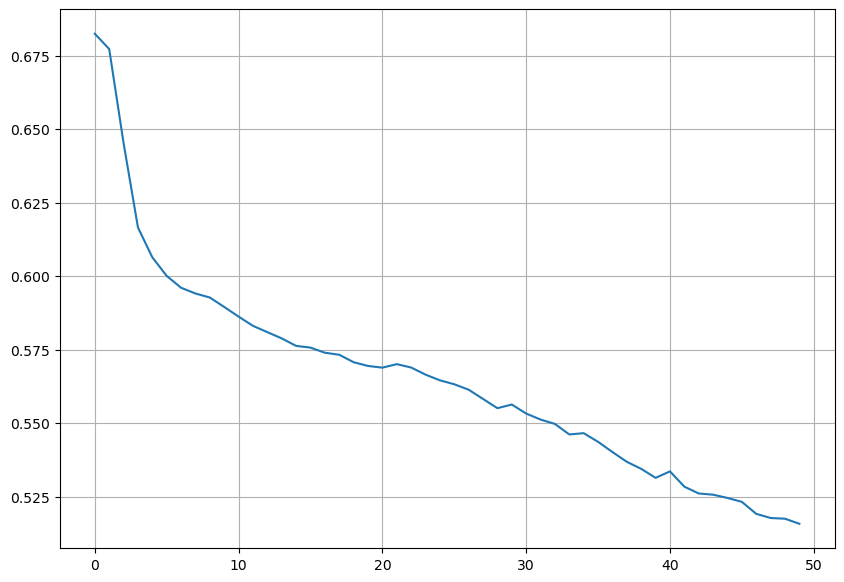

In [61]:
plt.figure(figsize=(10,7))
mvg_steps=question_sequence_len

#for i in range(len(loss_list)-mvg_steps):
#    loss_moving_avg.append(np.mean(loss_list[mvg_steps*i:(i+1)*mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


In [72]:
len(user_embedings)

192

(192, 2)

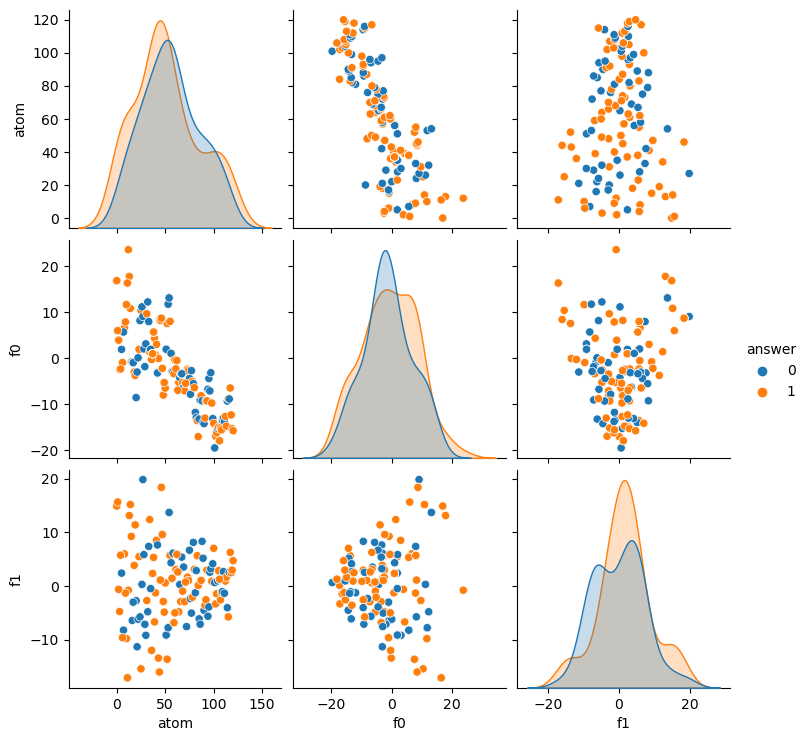

In [78]:
node_embeddings=[i[0] for i in user_embedings]

nodes=torch.stack(node_embeddings).detach().numpy()

nodesDf=pd.DataFrame(nodes[-question_sequence_len:])

pca = PCA(n_components=2)
components = pca.fit_transform(nodesDf)

#pcadf=pd.DataFrame({'f1':components[:,0],'f2':components[:,1]})
pcadf=pd.DataFrame({ 'f'+str(i):components[:,i]  for i in  range(components.shape[1]) })

answersdf=pd.DataFrame({'atom':question_sequence[1][lookback:],'answer':question_sequence[2][lookback:]})

pcadf=pcadf.reset_index().rename(columns={'index':'atom'})

answersdffea=answersdf.merge(pcadf,on='atom',how='left')

sns.pairplot(answersdffea,hue='answer')

In [91]:
dataset_train = TensorDataset(
    torch.stack(node_embeddings),
    torch.from_numpy(
np.asarray(question_sequence[2][lookback:] , dtype = np.float64)).float(),
)

In [93]:
len(dataset_train)

192

In [112]:
day1_10=torch.empty(10,3)
day2_11=torch.empty(10,3)
day3_12=torch.empty(10,3)
day4_13=torch.empty(10,3)

In [111]:
torch.stack([day1_10,day2_11,day3_12,day4_13]).shape

torch.Size([4, 10, 3])

In [115]:
day1=torch.empty(3)
day2=torch.empty(3)
day3=torch.empty(3)
day4=torch.empty(3)

In [119]:
torch.stack([day1,day2,day3])

tensor([[1.0751e-05, 8.3092e+20, 1.9991e+20],
        [1.0751e-05, 8.3092e+20, 1.9991e+20],
        [9.1477e-41, 1.8980e+01, 1.1210e-44]])

In [120]:
torch.stack([day1,day2,day3]).view(1,3,3)

tensor([[[1.0751e-05, 8.3092e+20, 1.9991e+20],
         [1.0751e-05, 8.3092e+20, 1.9991e+20],
         [9.1477e-41, 1.8980e+01, 1.1210e-44]]])

In [123]:
xx=[0,1,2,3]

In [124]:
xx[1]

1